In [45]:
!pip install kaggle
api_token = {"username":"amadeus1996","key":"9782cfe359c4c0bc913b36dcd2ede239"}
import json
import os
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /content/.kaggle/kaggle.json
!kaggle config set -n path -v /
!kaggle datasets download -d moltean/fruits

torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
path is now set to: /
fruits.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!pip3 install torchvision

In [33]:
!pip install Pillow==4.0.0
!pip install PIL
!pip install image
import PIL.image

    100% |████████████████████████████████| 5.6MB 7.8MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.2.0
    Uninstalling Pillow-5.2.0:
      Successfully uninstalled Pillow-5.2.0
  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL
    100% |████████████████████████████████| 7.1MB 4.4MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.


ModuleNotFoundError: ignored

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torchvision import datasets, transforms
from torch import nn
import IPython


In [47]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11439MB, multi_processor_count=13)

In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
import os
data_transforms = {
    'Training': transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor()
    ]),
    'Test': transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
    ]),
}

data_dir = '/datasets/moltean/fruits/fruits-360'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['Training', 'Test']}

In [0]:
dataset = image_datasets['Training']

In [0]:
BATCH_SIZE = 20
data_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.ConcatDataset([image_datasets['Training'], image_datasets['Test']]),
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True,
                                          num_workers=3, pin_memory = True)
# pin_memory if you're on GPU

In [0]:
n_batches = int(np.ceil(len(dataset)/ BATCH_SIZE)) # 60000 / 100


In [0]:

# Critic# Critic
# Note that we just have a linear output here
critic = nn.Sequential(
    nn.Linear(28 * 28 * 3, 512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1)
)

# Generator (takes a random seed of size 64 and generates an image of shape 80 x 80 x 3)
generator = nn.Sequential(
    nn.Linear(64, 128),
    nn.LeakyReLU(0.2),
    nn.Linear(128, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, 28 * 28 * 3),
    nn.Tanh()
)

# if you're running on GPU, move models there
if torch.cuda.is_available():
    critic.cuda()
    generator.cuda()

In [0]:

# These are the recommended defaults (sauf N_EPOCHS) from the WGAN paper.# These  
LR = 0.00005
N_EPOCHS = 1000
N_CRITIC_STEPS = 5
CLAMP = 0.02

In [0]:
critic_optimizer = torch.optim.RMSprop(critic.parameters(), lr=LR)
generator_optimizer = torch.optim.RMSprop(generator.parameters(), lr=LR)

In [0]:
from torch.autograd import Variable

def to_var(x):
    # first move to GPU, if necessary
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

In [0]:

import  torch.nn.functional  as F
from torchvision.utils import save_image

def denorm(x):
    # convert back from [-1, 1] to [0, 1]
    out = (x + 1) / 2
    return out #out.clamp(0, 1)

In [0]:
from google.colab import files


In [58]:
mkdir /wgan/weights

mkdir: cannot create directory ‘/wgan/weights’: File exists


In [59]:
# allow for manual keyboard interrupt
try: 
    # loop through epochs
    for epoch in range(N_EPOCHS):
        
        # Keep track of what critic step we're on
        crit_steps = 0
        
        # loop through batches (no need for class labels right now)
        for batch_number, (images, _) in enumerate(data_loader): 
            
            # this specific batch size (last one may not be equal to BATCH_SIZE)
            batch_size = images.shape[0] 
            
            # Reshape training dataset images from (batch_size, 28, 28) to (batch_size, 28*28) for 
            # processing through fully-connected net 
            images = to_var(images.view(batch_size, -1))

            # 1) TRAIN CRITIC
            # If we haven't done enough steps, let's train the critic
            if crit_steps < N_CRITIC_STEPS:
                critic.zero_grad()
                generator.zero_grad()
        
                # clamp parameters to a cube
                for p in critic.parameters():
                    p.data.clamp_(-CLAMP, CLAMP)

                # Accum grads with real images (we want the critic to output a high value here)
                err_real = torch.mean(critic(images))
            
                # Draw random 64-dimensional noise vectors as inputs to the generator network
                z = to_var(torch.randn(batch_size, 64))
                
                # Transform the noise through the generator network to get synthetic images
                fake_images = generator(z)
                
                # Accum grads with fake images (we want the critic to output a low value here)
                err_fake = torch.mean(critic(fake_images)) 
                
                # If we minimize this, we maximize err_real - err_fake
                critic_loss = err_fake - err_real
                critic_loss.backward()
                critic_optimizer.step()
                
                # We increment our counter now that we've seen a critic update
                crit_steps += 1
            # 2) TRAIN GENERATOR
            # Here we have done N_CRITIC_STEPS critic updates, so we do the generator now
            else:
                critic.zero_grad()
                generator.zero_grad()

                # Draw random 64-dimensional noise vectors as inputs to the generator network
                z = to_var(torch.randn(batch_size, 64))
                
                # Transform the noise through the generator network to get synthetic images
                fake_images = generator(z)
                
                # Accum grads with fake images (generator wants the critic to 
                # output a high value here, "tricking" it)
                outputs = critic(fake_images)
                
                # We minimize this so we maximize the quantity we actually care about
                generator_loss = -torch.mean(outputs)

                # Backprop + Optimize the generator
                generator_loss.backward()
                generator_optimizer.step()
                
                # Reset the counter - the next batch will go to the critic!
                crit_steps = 0

        if (epoch % 50 == 0):
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, '
                          'g_loss: %.4f, Mean D(x): %.2f, Mean D(G(z)): %.2f' 
                          %(epoch,
                            N_EPOCHS,
                            batch_number + 1,
                            n_batches,
                            critic_loss.item(),
                            generator_loss.item(),
                            err_real.data.mean(),
                            err_fake.data.mean())
                    )

        # Save real images once
        if (epoch + 1) == 1:
            images = images.view(images.size(0), 3, 28, 28) # reshape
            save_image(denorm(images.data), '/wgan/data/wgan_real_images.png')

        if(epoch%50 == 1):
        # Save sampled images
            fake_images = fake_images.view(fake_images.size(0), 3, 28, 28) #reshape
            save_image(denorm(fake_images.data), '/wgan/data/wgan_fake_images-%0.3d.png' %(epoch + 1))
            files.download('/wgan/data/wgan_fake_images-%0.3d.png' %(epoch + 1))
        # Save the trained parameters 
            torch.save(generator.state_dict(), '/wgan/weights/wgan_generator-%0.3d.pkl' %(epoch + 1))
            files.download('/wgan/weights/wgan_generator-%0.3d.pkl' %(epoch + 1))
            torch.save(critic.state_dict(), '/wgan/weights/wgan_discriminator-%0.3d.pkl' %(epoch + 1))
            files.download('/wgan/weights/wgan_discriminator-%0.3d.pkl' %(epoch + 1))
        
except KeyboardInterrupt:
    print ('Training ended early.')

Epoch [0/1000], Step[2528/1892], d_loss: -4.5467, g_loss: -33.2077, Mean D(x): 36.33, Mean D(G(z)): 31.79
Epoch [50/1000], Step[2528/1892], d_loss: 0.0947, g_loss: -12.1278, Mean D(x): 11.59, Mean D(G(z)): 11.68


MessageError: ignored

In [38]:
!ls

datalab


In [0]:
# Load back saved weights (we have these pre-trained)
generator.load_state_dict(torch.load('weights/wgan_generator-4901.pkl'))
critic.load_state_dict(torch.load('weights/wgan_discriminator-4901.pkl'))

In [0]:
NB_SAMPLES = 40
z = to_var(torch.randn(NB_SAMPLES, 64))
fake_images = generator(z)

In [0]:
save_image(denorm(fake_images.view(fake_images.size(0), 3, 80, 80).data), # reshape
           './data/wgan_fake_images_final.png', nrow=20)

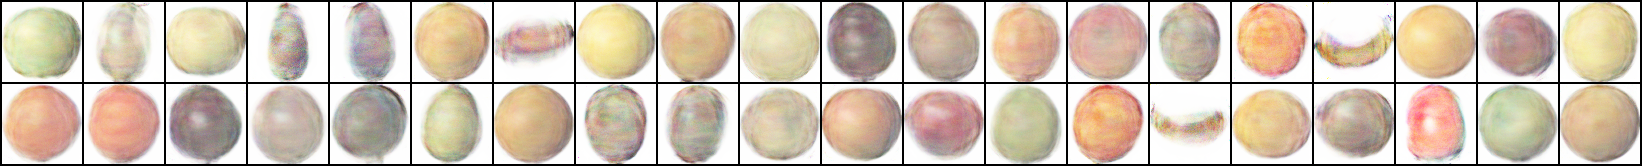

In [0]:
IPython.display.Image('./data/wgan_fake_images_final.png')